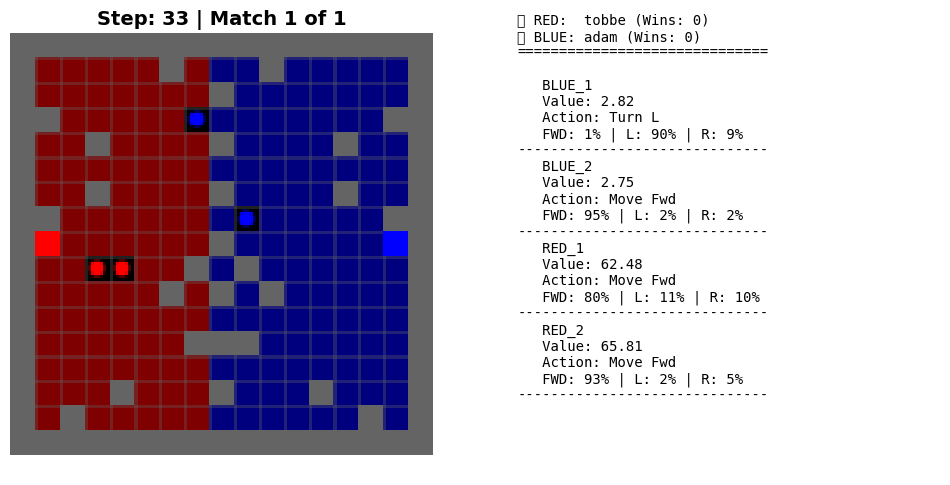

In [ ]:
import os
import glob
import time
import random
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from stable_baselines3 import PPO 
from ctf_env import CaptureTheFlagPZ
import torch

# --- CONFIGURATION ---
MODELS_DIR = "models"
MATCHES_PER_SERIES = 1
RENDER_MODE = "rgb_array"
GAME_FPS = 60
SLEEP_TIME = 0.01 / GAME_FPS 

# Global log storage
TOURNAMENT_LOGS = []

def load_models_from_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created '{directory}' directory. Please put your model .zip files here!")
        return {}

    model_files = glob.glob(os.path.join(directory, "*.zip"))
    models = {}
    print(f"Loading models from {directory}...")
    for f in model_files:
        name = os.path.basename(f).replace(".zip", "")
        try:
            models[name] = PPO.load(f) 
            print(f" - Loaded: {name}")
        except Exception as e:
            print(f" ! Failed to load {name}: {e}")
    return models

def save_logs_to_file():
    """Saves the collected logs to a JSON file."""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"tournament_log_{timestamp}.json"
    
    def default_converter(o):
        if isinstance(o, (np.int64, np.int32)): return int(o)
        if isinstance(o, (np.float64, np.float32)): return float(o)
        if isinstance(o, np.ndarray): return o.tolist()
        return str(o)

    with open(filename, 'w') as f:
        json.dump(TOURNAMENT_LOGS, f, default=default_converter, indent=2)
    
    print(f"\n✅ LOGS SAVED TO: {filename}")
    print("You can upload this file for analysis!")

def run_matchup_and_log(env, red_name, red_model, blue_name, blue_model, match_label=""):
    series_wins = {red_name: 0, blue_name: 0, "draw": 0}
    match_history = [] # Stores results like "Game 1: RED"
    
    action_names = ["Turn R", "Turn L", "Move Fwd", "Pickup", "Drop", "Toggle", "Done"]

    print(f"\n{'='*40}")
    print(f"MATCH: {red_name} (Red) vs {blue_name} (Blue)")
    print(f"{'='*40}\n")
    time.sleep(2)

    for i in range(MATCHES_PER_SERIES):
        observations, _ = env.reset()
        step_count = 0
        
        # Match Log Container
        match_data = {
            "match_label": match_label,
            "game_number": i + 1,
            "red_team": red_name,
            "blue_team": blue_name,
            "steps": []
        }

        while env.agents:
            actions = {}
            agent_thoughts = {} 

            for agent_id in env.agents:
                obs = observations[agent_id]
                formatted_obs = {
                    "image": np.array(obs["image"])[None, :],
                    "role": np.array(obs["role"])[None, :]
                }
                
                # Identify Team & Model
                if "red" in agent_id:
                    model = red_model
                    current_model_name = red_name
                else:
                    model = blue_model
                    current_model_name = blue_name

                # --- EXTRACT BRAIN DATA ---
                obs_tensor, _ = model.policy.obs_to_tensor(formatted_obs)
                
                with torch.no_grad():
                    # 1. Action Probabilities
                    dist = model.policy.get_distribution(obs_tensor)
                    probs = dist.distribution.probs[0].cpu().numpy()
                    
                    # 2. Value Estimate
                    features = model.policy.extract_features(obs_tensor)
                    latent_pi, latent_vf = model.policy.mlp_extractor(features)
                    value = model.policy.value_net(latent_vf)[0].item()

                act, _ = model.predict(formatted_obs, deterministic=False)
                actions[agent_id] = int(act[0])
                
                # Save Data
                thought_data = {
                    "agent": agent_id,
                    "model": current_model_name,
                    "value": value,
                    "probs": probs, 
                    "action": int(actions[agent_id]),
                    "action_name": action_names[int(actions[agent_id])],
                    "has_flag": env.unwrapped.carrying_flag.get(agent_id, False)
                }
                agent_thoughts[agent_id] = thought_data

            # Record step log
            match_data["steps"].append({
                "step": step_count,
                "thoughts": agent_thoughts
            })

            # Step Environment
            observations, rewards, terms, truncs, infos = env.step(actions)
            step_count += 1

            # --- RENDER WITH NAMES & DATA ---
            frame = env.unwrapped.render()
            
            plt.figure(figsize=(12, 6))
            
            # Subplot 1: Game
            plt.subplot(1, 2, 1)
            plt.imshow(frame)
            plt.axis('off')
            plt.title(f"Step: {step_count} | Match {i+1} of {MATCHES_PER_SERIES}", fontsize=14, fontweight='bold')

            # Subplot 2: HUD
            plt.subplot(1, 2, 2)
            plt.axis('off')
            
            # --- UPDATED SCOREBOARD HEADER ---
            hud_text =  f"🟥 RED:  {red_name[:10]} (Wins: {series_wins[red_name]})\n"
            hud_text += f"🟦 BLUE: {blue_name[:10]} (Wins: {series_wins[blue_name]})\n"
            
            # Show history of previous games in this series
            if match_history:
                hud_text += "-"*30 + "\n"
                for entry in match_history:
                    hud_text += f" {entry}\n"
            
            hud_text += "="*30 + "\n\n"
            
            sorted_agents = sorted(agent_thoughts.keys())
            
            for agent_id in sorted_agents:
                data = agent_thoughts[agent_id]
                val = data["value"]
                act_name = data["action_name"]
                probs = data["probs"]
                
                flag_icon = "🚩" if data["has_flag"] else "  "
                
                hud_text += f"{flag_icon} {agent_id.upper()}\n"
                hud_text += f"   Value: {val:.2f}\n"
                hud_text += f"   Action: {act_name}\n"
                
                p_fwd = probs[2] * 100
                p_left = probs[1] * 100
                p_right = probs[0] * 100
                
                hud_text += f"   FWD: {p_fwd:.0f}% | L: {p_left:.0f}% | R: {p_right:.0f}%\n"
                hud_text += "-"*30 + "\n"

            plt.text(0, 1, hud_text, fontsize=10, family='monospace', verticalalignment='top')
            plt.show()
            
            time.sleep(SLEEP_TIME) 
            clear_output(wait=True)

            # --- CHECK WIN ---
            if any(terms.values()) or any(truncs.values()):
                red_reward = max([rewards.get(a, 0) for a in rewards if "red" in a] + [-1])
                blue_reward = max([rewards.get(a, 0) for a in rewards if "blue" in a] + [-1])
                
                winner_log = "DRAW"
                if red_reward > 5.0:
                    series_wins[red_name] += 1
                    winner_log = red_name
                    match_history.append(f"G{i+1}: 🟥 {red_name} Won")
                    print(f"Game {i+1} Winner: {red_name}!")
                elif blue_reward > 5.0:
                    series_wins[blue_name] += 1
                    winner_log = blue_name
                    match_history.append(f"G{i+1}: 🟦 {blue_name} Won")
                    print(f"Game {i+1} Winner: {blue_name}!")
                else:
                    series_wins["draw"] += 1
                    match_history.append(f"G{i+1}: ⬜ Draw")
                    print(f"Game {i+1} Result: Draw")
                
                # Add result to log
                match_data["result"] = winner_log
                TOURNAMENT_LOGS.append(match_data)
                
                time.sleep(1)
                break
    
    if series_wins[red_name] > series_wins[blue_name]:
        return red_name
    elif series_wins[blue_name] > series_wins[red_name]:
        return blue_name
    else:
        return random.choice([red_name, blue_name])

# --- MAIN TOURNAMENT LOOP ---
def run_tournament():
    env = CaptureTheFlagPZ(render_mode=RENDER_MODE)
    loaded_models = load_models_from_dir(MODELS_DIR)
    
    if len(loaded_models) < 2:
        print("Not enough models! Add 2+ .zip files to 'models/'")
        return

    bracket = list(loaded_models.keys())
    random.shuffle(bracket)
    round_num = 1

    print(f"Tournament Initialized: {bracket}")
    time.sleep(3)

    while len(bracket) > 1:
        next_round_bracket = []
        print(f"\n{'#'*30}\n ROUND {round_num} \n{'#'*30}")
        
        for i in range(0, len(bracket), 2):
            if i + 1 >= len(bracket):
                next_round_bracket.append(bracket[i])
                break
            
            team_a = bracket[i]
            team_b = bracket[i+1]
            
            winner = run_matchup_and_log(
                env, 
                team_a, loaded_models[team_a], 
                team_b, loaded_models[team_b],
                match_label=f"ROUND {round_num}"
            )
            
            next_round_bracket.append(winner)
        
        bracket = next_round_bracket
        round_num += 1

    print(f"\n CHAMPION: {bracket[0]} ")
    
    # SAVE THE LOGS AT THE END
    save_logs_to_file()

if __name__ == "__main__":
    run_tournament()